In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import matplotlib.pyplot as plt

start_date = '2019-01-01'
end_date = '2022-01-01'

dates = pd.date_range(start=start_date, end=end_date, freq='D')
unix_dates = np.array([int(pd.Timestamp(d).timestamp()) for d in dates])
# Recreate a DatetimeIndex with a specific frequency

freq = 'D'  # Monthly frequency
date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

prices = np.sin(unix_dates)

for i in range(len(prices)):
    prices[i] = prices[i] + float(i) / 50

data = pd.DataFrame({'ds': date_rng, 'y': prices})
# Prepare data
data['ds_numeric'] = data['ds'].apply(lambda x: x.value)  # Convert dates to numeric

In [34]:
X = data[['ds_numeric']]  # Input features
y = data['y']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, shuffle = False)

In [35]:
prices

array([-0.88537088, -0.90014484, -0.90886134, ..., 20.93720384,
       20.98733341, 21.04347122])

In [36]:
# Define the parameter search space for CatBoost
catboost_param_space = {
    'depth': (3, 6, 12),
    'learning_rate': (0.001, 0.01, 0.3),
    'n_estimators': (1, 10, 50, 500)
}

# Define the parameter search space for XGBoost
xgboost_param_space = {
    'max_depth': (3, 6, 12),
    'learning_rate': (0.001, 0.01, 0.3),
    'n_estimators': (1, 10, 50, 500)
}

# Define the parameter search space for LightGBM
lightgbm_param_space = {
    'max_depth': (3, 6, 12),
    'learning_rate': (0.001, 0.01, 0.3),
    'n_estimators': (1, 10, 50, 500)
}

In [37]:
# Create lists of models and their corresponding parameter search spaces
rand_state = 0
models = [CatBoostRegressor(), XGBRegressor(), LGBMRegressor()]
param_spaces = [catboost_param_space, xgboost_param_space, lightgbm_param_space]

best_mape = float('inf')  # Initialize with a large value
best_model = None
best_params = None

In [38]:
# Loop through models and their parameter spaces
for model, param_space in zip(models, param_spaces):
    # Perform Bayesian optimization
    bayes_cv_tuner = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        n_iter=50,
        scoring='neg_mean_absolute_percentage_error',  # Negative MAPE for optimization
        cv = KFold(n_splits=3, shuffle=True, random_state=rand_state),
        n_jobs = -1
    )
    
    # Fit the model
    bayes_cv_tuner.fit(X_train, y_train)
    
    # Get the best parameters and best MAPE
    if -bayes_cv_tuner.best_score_ < best_mape:
        best_mape = -bayes_cv_tuner.best_score_
        best_model = model
        best_params = bayes_cv_tuner.best_params_


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [118]:
# Train the best model with the best parameters
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [119]:
# Make predictions
y_pred = best_model.predict(X_test)

In [120]:

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 11.34%


In [121]:
len(y_pred)

220

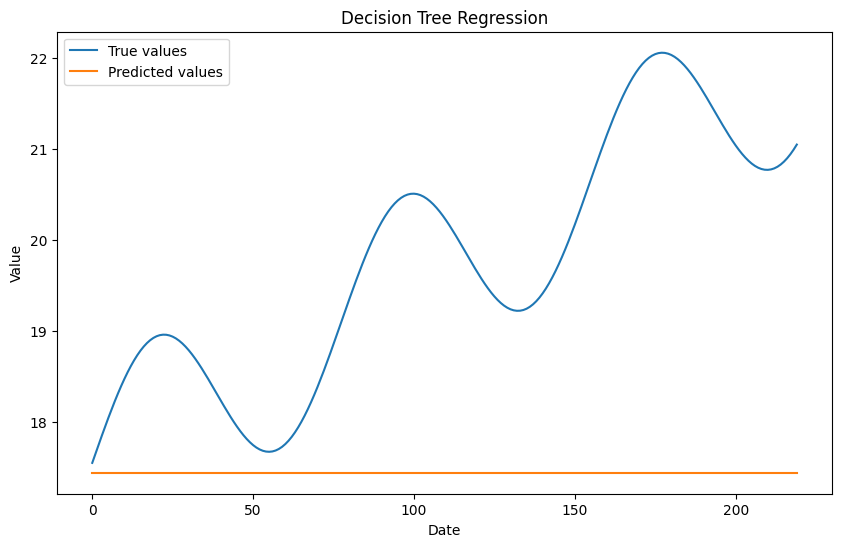

In [122]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(data['y'][-len(y_pred):].values, label='True values')
#plt.plot(X_test['ds_numeric'], y_pred, label='Predicted values')
plt.plot(y_pred, label='Predicted values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

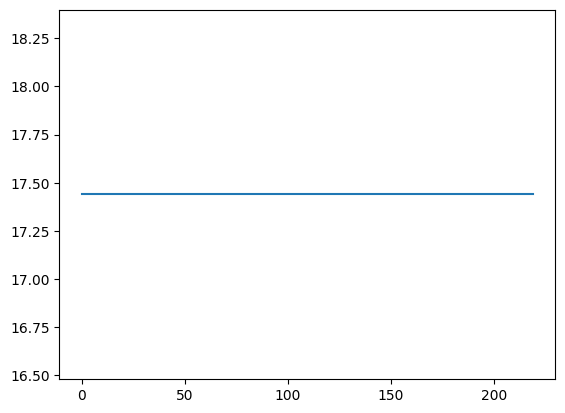

In [123]:
plt.plot(y_pred, label='Predicted values')